In [1]:
%run init_notebookspace.py
from settings import *

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\macro_rbc\data


In [2]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp

import matplotlib.pyplot as plt

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def compare_steady_states(models, names):
    all_keys = set()
    for model in models:        all_keys = all_keys.union(set(list(model.steady_state_dict.keys())))
    
    header = ' ' * 10 + ''.join([f'{name:>10}' for name in names])
    print(header)
    print('-' * len(header))

    for key in all_keys:
        line = f'{key:<10}'
        for model in models:
            if key in model.steady_state_dict.keys():
                value = f'{model.steady_state_dict[key]:>10.3f}'
            else:
                value = f'{"---":>10}'
            line += value 
        print(line)

# Table of contents

# Basic RBC

In [4]:
rbc_base = ge.gEconModel(os.path.join(DATA_DIR, "rbc_basic.gnc"))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [5]:
rbc_base.steady_state()
rbc_base.solve_model()

print('\nSteady State')
rbc_base.print_steady_state()

print('\nBlanchard Kahn Conditions')
rbc_base.check_bk_condition();

Steady state found! Sum of squared residuals is 4.2182281477579137e-19
Solution found, sum of squared residuals:  5.619368932851024e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000

Steady State
A_ss               1.000
C_ss               1.235
I_ss               0.185
K_ss              18.508
L_ss               0.571
Y_ss               1.420
lambda_ss          0.407
r_ss               0.020
w_ss               1.836

Blanchard Kahn Conditions
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Impulse Response function

Impulse response for K is rather sharp, this does not correspond to reality, which can be better approximated with capital adjustment cost.

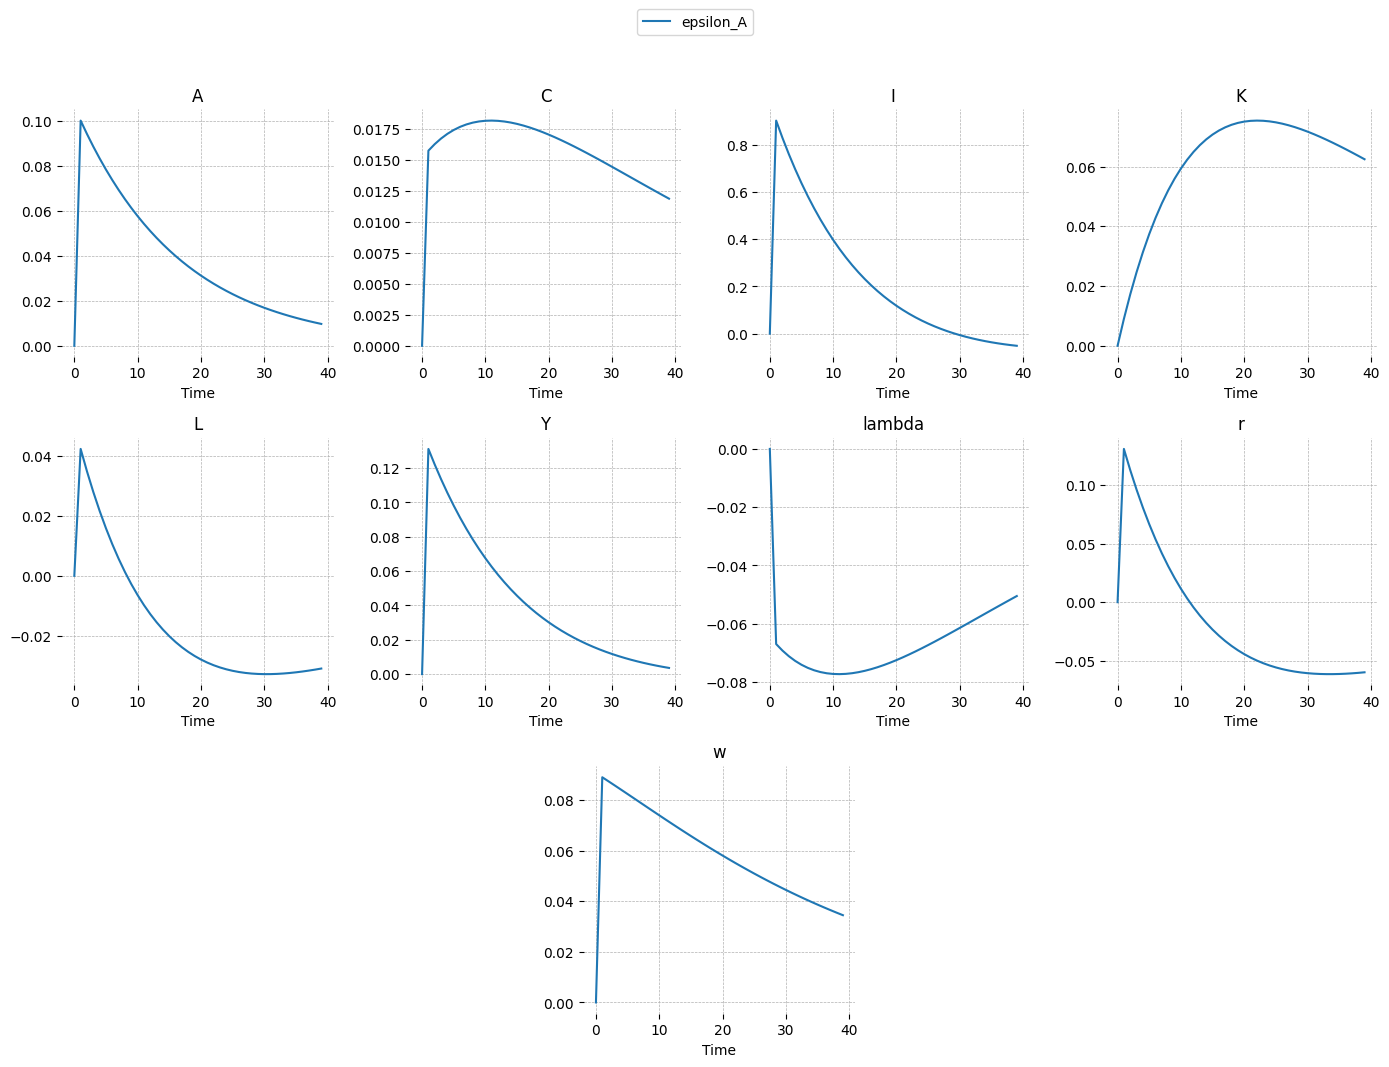

In [6]:
base_irf = rbc_base.impulse_response_function(simulation_length=40, shock_size=.1)
gp.plot_irf(base_irf, legend=True);

Why is the cov on I so high? Investment are the most volatile variable in economic model, and if we take the square root of the variance the s.d. is near 2.3 which seems reasonable

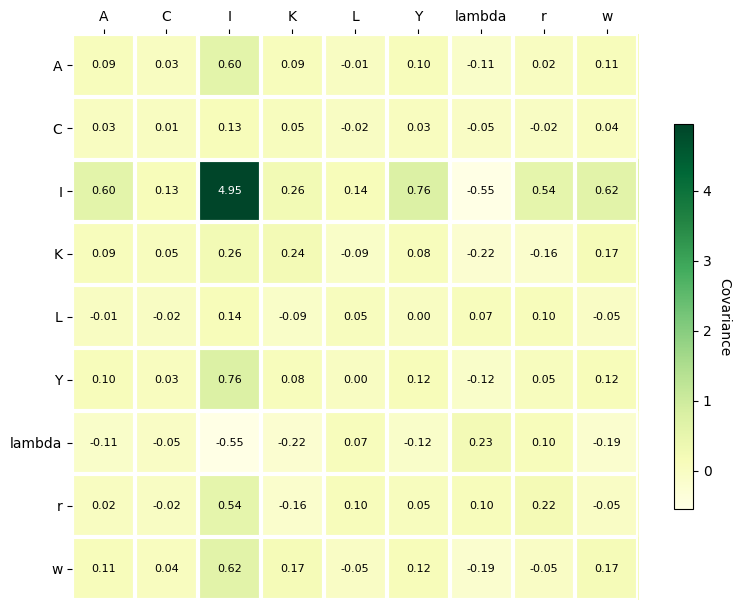

In [7]:
gp.plot_covariance_matrix(rbc_base.compute_stationary_covariance_matrix(), cbar_kw={'shrink': 0.5});

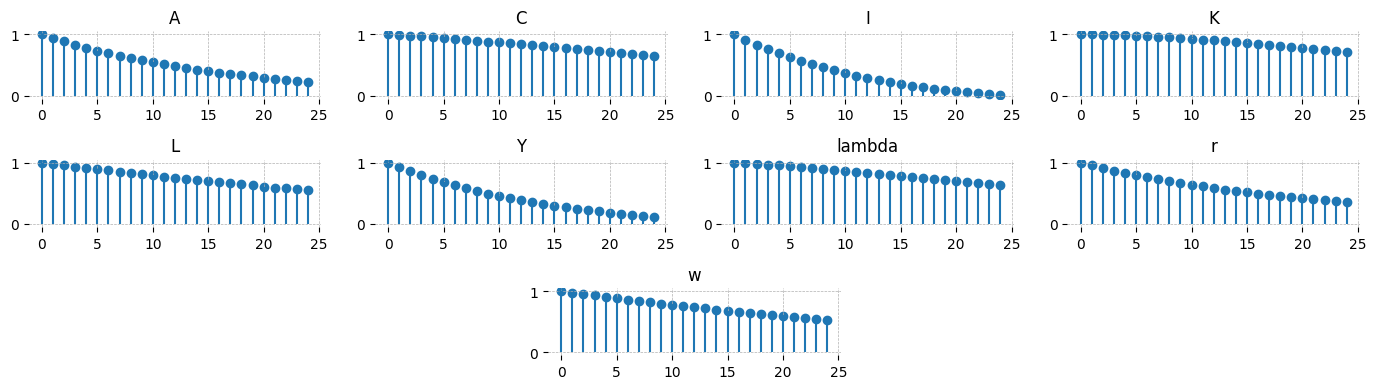

In [8]:
gp.plot_acf(rbc_base.compute_autocorrelation_matrix(n_lags=25));

# Capital Adjustment Cost

In [9]:
rbc_capadj = ge.gEconModel(os.path.join(DATA_DIR, "rbc_capadj.gnc"))

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [10]:
rbc_capadj.steady_state()
rbc_capadj.solve_model()
print('\nSteady State')
rbc_capadj.print_steady_state()

print('\n\nBlanchard Kahn Conditions')
rbc_capadj.check_bk_condition();

Steady state found! Sum of squared residuals is 8.42028608748252e-31
Solution found, sum of squared residuals:  1.1188166266847495e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000

Steady State
A_ss               1.000
C_ss               1.615
I_ss               0.489
K_ss              24.472
L_ss               0.562
Q_ss               1.000
Y_ss               2.105
lambda_ss          0.130
q_ss               0.130
r_ss               0.030
w_ss               2.436


Blanchard Kahn Conditions
Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


In [11]:
for eq in rbc_capadj.steady_state_system:
    display(eq)

-Q_ss + lambda_ss/q_ss

-C_ss - I_ss + K_ss*r_ss + L_ss*w_ss

-phi*K_ss*(-delta + I_ss/K_ss)**2/2 + I_ss + K_ss*(1 - delta) - K_ss

-lambda_ss + C_ss**(-sigma_C)

-L_ss**sigma_L + lambda_ss*w_ss

-lambda_ss - q_ss*(phi*(-delta + I_ss/K_ss) - 1)

beta*(lambda_ss*r_ss - q_ss*(delta - phi*I_ss*(-delta + I_ss/K_ss)/K_ss + phi*(-delta + I_ss/K_ss)**2/2 - 1)) - q_ss

A_ss*K_ss**alpha*L_ss**(1 - alpha) - Y_ss

alpha*A_ss*K_ss**(alpha - 1)*L_ss**(1 - alpha) - r_ss

A_ss*K_ss**alpha*(1 - alpha)/L_ss**alpha - w_ss

rho_A*log(A_ss) - log(A_ss)

## Impulse Response function

Capital adjustment shows the expected behaviour of a more hump-shaped adjustment to shocks in Y. Important to note is also the effect on C. With capital adjustment cost a higher share of the initial income is consumed, wherefore consumption deviates further from its steady state and its reversion is less sharp.

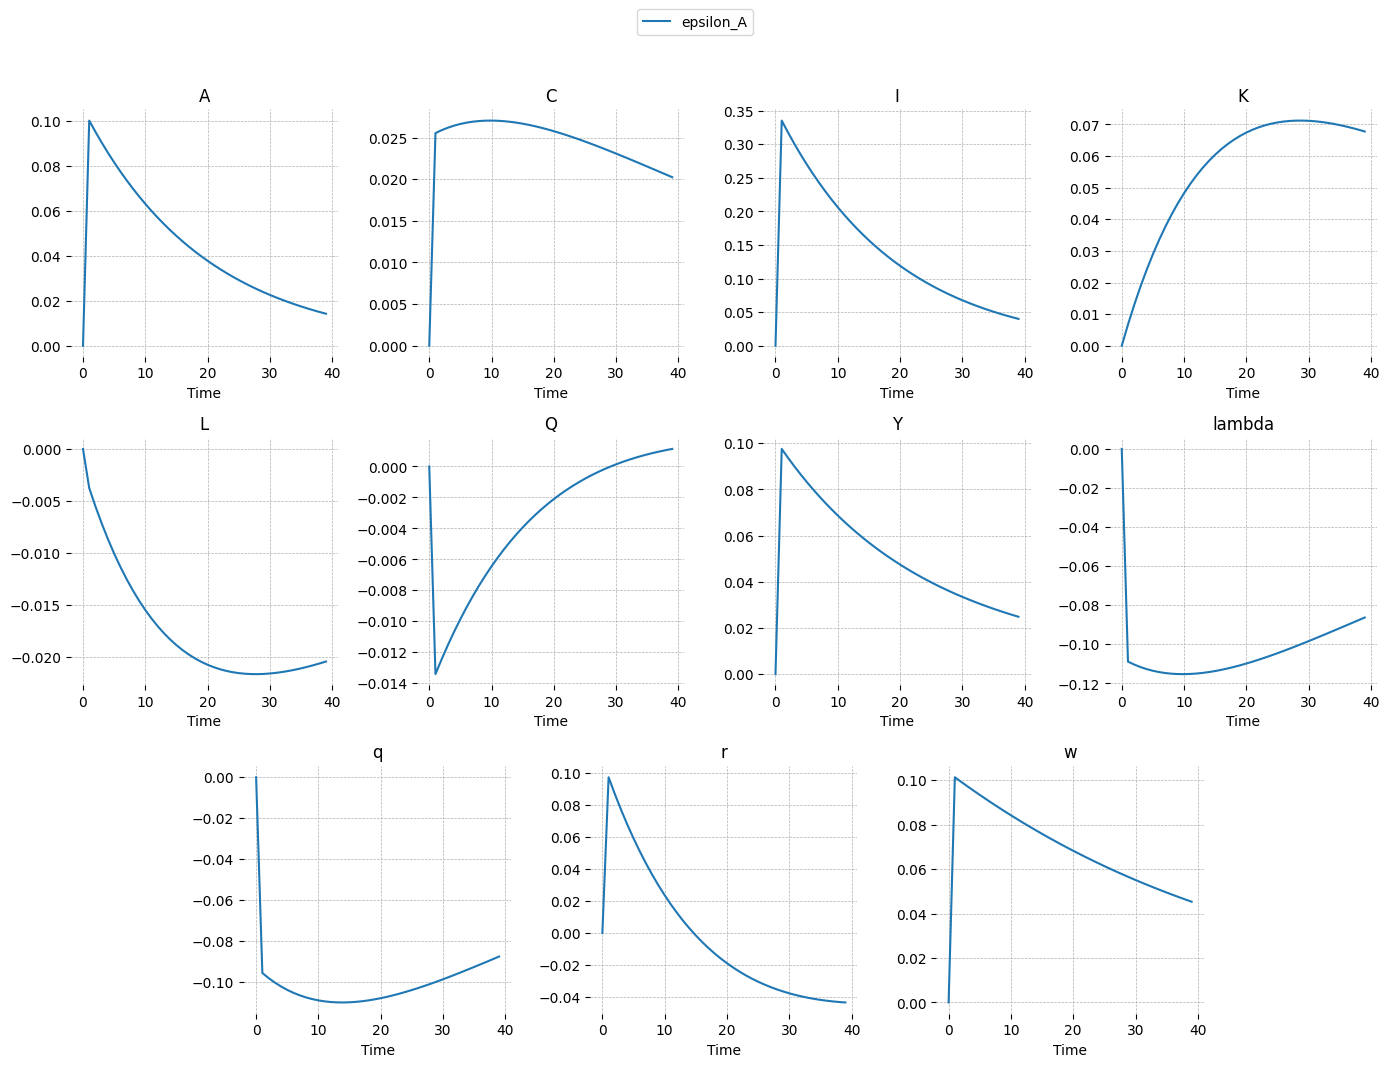

In [12]:
capajd_irf = rbc_capadj.impulse_response_function(simulation_length=40, shock_size=.1)
gp.plot_irf(capajd_irf, legend=True);

Why is the cov on I so high?

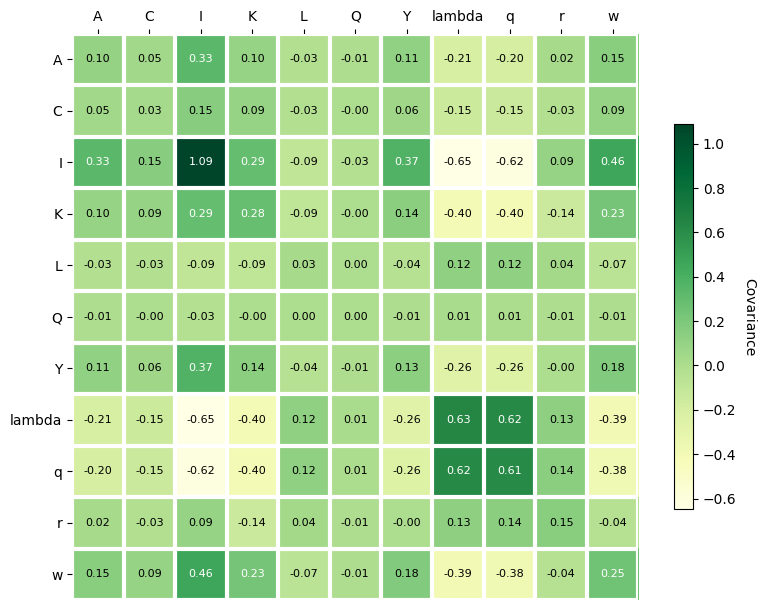

In [13]:
gp.plot_covariance_matrix(rbc_capadj.compute_stationary_covariance_matrix(), cbar_kw={'shrink': 0.5});

The hump shaped behaviour of K can also be seen in its autocorrelation function, as the reaction is smoothed out values are more highly correlated and tail off far slower than in the basic model. Capital adjusment costs, have a similar effect on consumption. As income is not directly put towards capital more is left for consumption, leading to a similarly smoothed out consumption pattern and thus higher autocorrelation with longer tail.

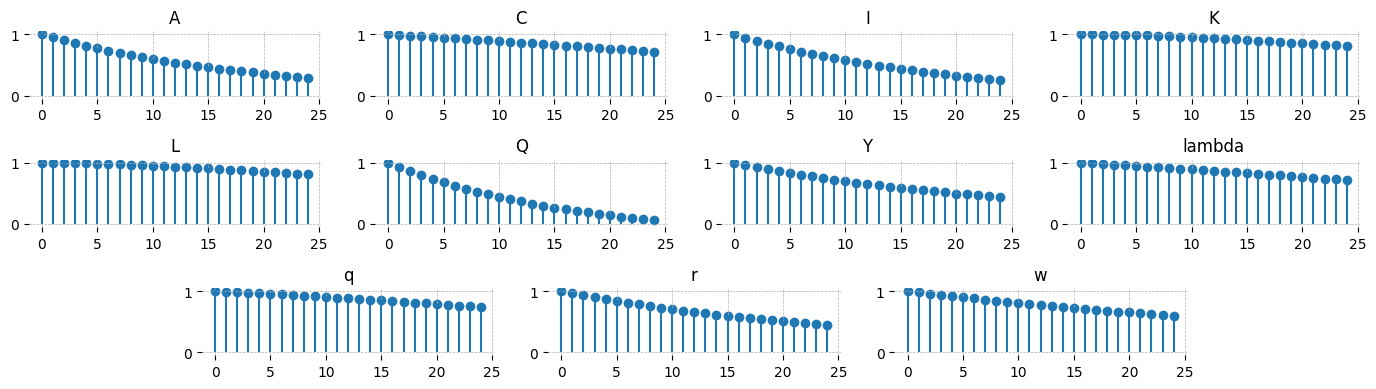

In [14]:
gp.plot_acf(rbc_capadj.compute_autocorrelation_matrix(n_lags=25));

# Bonds RBC

In [15]:
rbc_bonds = ge.gEconModel(os.path.join(DATA_DIR, "rbc_bonds.gnc"))

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [16]:
rbc_bonds.steady_state()
rbc_bonds.solve_model(not_loglin_variable=['Div', 'TC'])
print('\nSteady State')
rbc_bonds.print_steady_state()

print('\n\nBlanchard Kahn Conditions')
rbc_bonds.check_bk_condition();

Steady state found! Sum of squared residuals is 8.42028608748252e-31
Solution found, sum of squared residuals:  2.22220959721428e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000

Steady State
A_ss               1.000
C_ss               1.615
Div_ss             0.000
I_ss               0.489
K_ss              24.472
L_ss               0.562
TC_ss             -2.105
Y_ss               2.105
lambda_ss          0.130
r_G_ss             1.010
r_ss               0.030
w_ss               2.436


Blanchard Kahn Conditions
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


In [17]:
for eq in rbc_bonds.steady_state_system:
    display(eq)

-C_ss + Div_ss - I_ss + K_ss*r_ss + L_ss*w_ss

I_ss + K_ss*(1 - delta) - K_ss

-lambda_ss + C_ss**(-sigma_C)

-L_ss**sigma_L + lambda_ss*w_ss

beta*(lambda_ss*r_ss - lambda_ss*(delta - 1)) - lambda_ss

beta*lambda_ss - lambda_ss/r_G_ss

-Div_ss + TC_ss + Y_ss

A_ss*K_ss**alpha*L_ss**(1 - alpha) - Y_ss

-K_ss*r_ss - L_ss*w_ss - TC_ss

alpha*A_ss*K_ss**(alpha - 1)*L_ss**(1 - alpha) - r_ss

A_ss*K_ss**alpha*(1 - alpha)/L_ss**alpha - w_ss

rho_A*log(A_ss) - log(A_ss)

## Impulse Response function

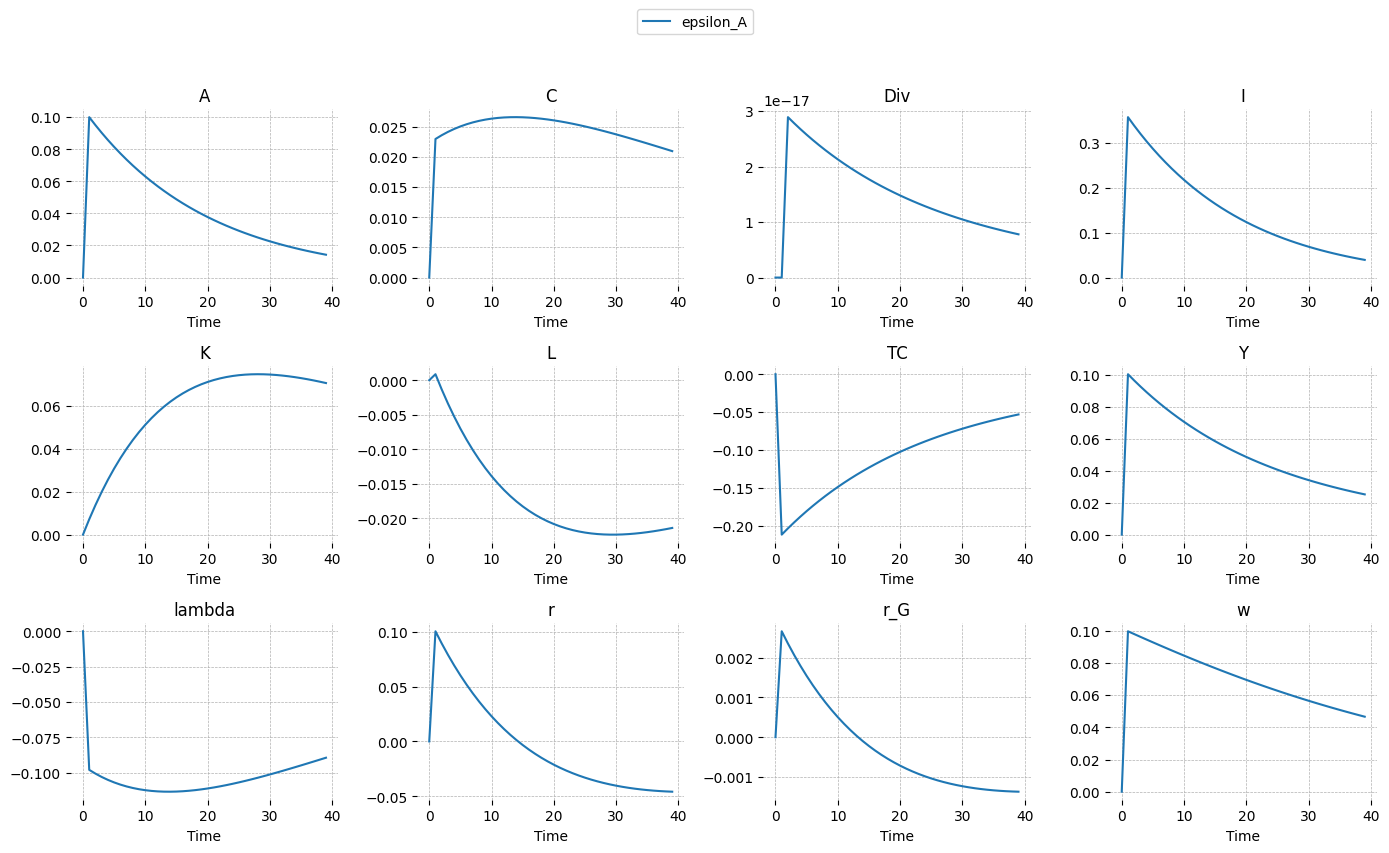

In [18]:
bonds_irf = rbc_bonds.impulse_response_function(simulation_length=40, shock_size=.1)
gp.plot_irf(bonds_irf, legend=True);

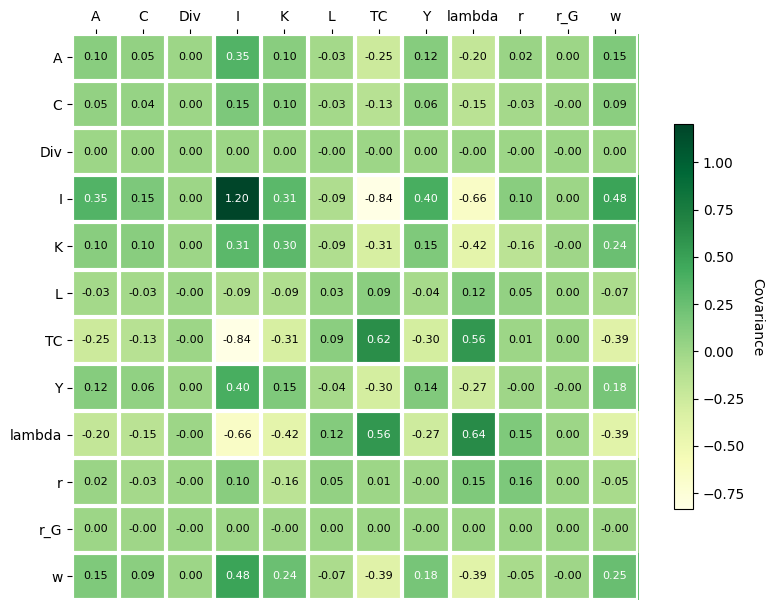

In [19]:
gp.plot_covariance_matrix(rbc_bonds.compute_stationary_covariance_matrix(), cbar_kw={'shrink': 0.5});

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\gEconpy\plotting\plotting.py:397: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


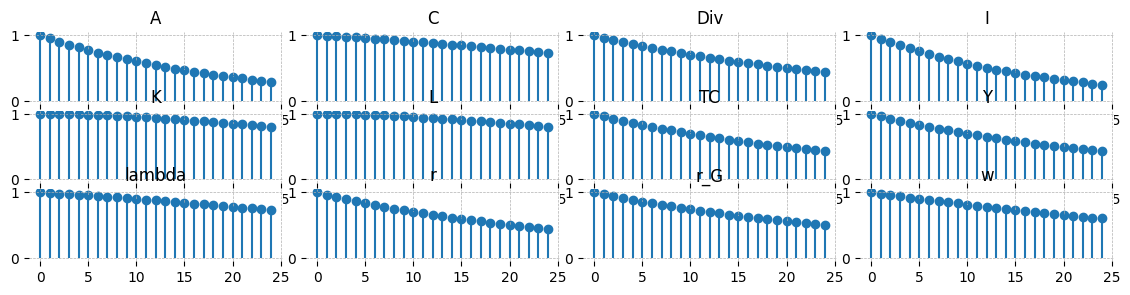

In [20]:
gp.plot_acf(rbc_bonds.compute_autocorrelation_matrix(n_lags=25));

# Compare Steady states

In [21]:
compare_steady_states([rbc_base, rbc_capadj, rbc_bonds], ['Baseline', 'K Adj', 'Bonds'])

            Baseline     K Adj     Bonds
----------------------------------------
r_G_ss           ---       ---     1.010
A_ss           1.000     1.000     1.000
w_ss           1.836     2.436     2.436
K_ss          18.508    24.472    24.472
C_ss           1.235     1.615     1.615
Div_ss           ---       ---     0.000
I_ss           0.185     0.489     0.489
lambda_ss      0.407     0.130     0.130
r_ss           0.020     0.030     0.030
Y_ss           1.420     2.105     2.105
TC_ss            ---       ---    -2.105
L_ss           0.571     0.562     0.562
Q_ss             ---     1.000       ---
q_ss             ---     0.130       ---
